### **HOMEWORK 2**  <h3>

### **Exercício 1**  <h3>
#### **a)** <h4>

Inicialmente temos que ler o DataSet. 

In [122]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.io.arff import loadarff
from scipy.stats import ttest_rel

# Reading the file
data = loadarff('column_diagnosis.arff')
df = pd.DataFrame(data[0])
df['class'] = df['class'].str.decode('utf-8')

De seguida, é necessário separar os dados em dois grupos: um para as features (variáveis de input) e outro para as classes (variáveis de output).

In [123]:
X = df.drop('class', axis=1) 
y = df['class'] 

De seguida, fizemos stratified cross-validation e inicializámos os classificadores kNN  (k=5) e Naive Bayes.

In [124]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

knn = KNeighborsClassifier(n_neighbors=5)
nb = GaussianNB()

In [125]:
scores_knn = cross_val_score(knn, X, y, cv=cv, scoring='accuracy')
scores_nb = cross_val_score(nb, X, y, cv=cv, scoring='accuracy')

scores_list = [scores_knn, scores_nb]

Fizemos os boxplots com as fold accuracies para os dois classificadores.

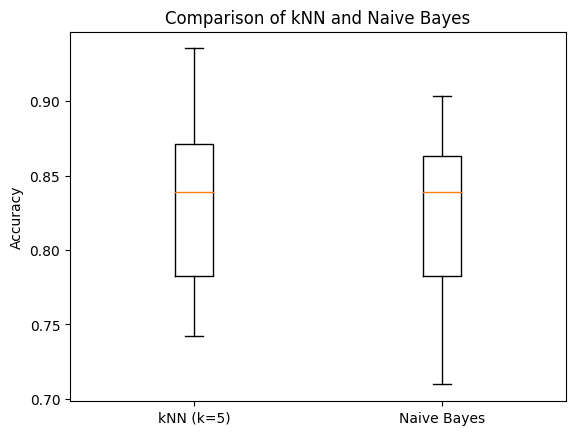

In [126]:
fig, ax = plt.subplots()

ax.boxplot(scores_list)
ax.set_xticklabels(['kNN (k=5)', 'Naive Bayes'])
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of kNN and Naive Bayes')
plt.show()

#### **b)** <h4>

Utilizámos o t-test para testar a hipótese de que kNN é estatisticamente superior a Naive Bayes relativamente à accuracy.

In [127]:
t_stat, p_value = ttest_rel(scores_knn, scores_nb, alternative='greater')

print('t-statistic:', t_stat)
print('p-value:', p_value)


t-statistic: 0.9214426752509264
p-value: 0.19042809062064092


Como o valor de p-value obtido  ́e superior a 0.05 (valor de significância usual), então rejeitamos a hipótese colocada, pelo que kNN não é estatisticamente superior a Naive Bayes, relativamente à accuracy.

### **Exercício 2**  <h3>

Inicializámos os classificadores kNN para k=1 e k=5.

In [128]:
knn1 = KNeighborsClassifier(n_neighbors=1, weights='uniform', metric='euclidean')
knn5 = KNeighborsClassifier(n_neighbors=5, weights='uniform', metric='euclidean')

Criámos as matrizes de confusão para os dois classificadores.

In [129]:
cm1_total = np.zeros((3, 3))
cm5_total = np.zeros((3, 3))

Para cada uma das 10 folds obtivemos os X e y de treino e teste, assim como os y de teste previstos. Calculámos as matrizes de confusão para os dois classificadores e somámos às matrizes de confusão globais.

In [130]:
for train_k, test_k in cv.split(X, y):
    # Obter os X e y de teste e treino  
    X_train, X_test = X.iloc[train_k], X.iloc[test_k]
    y_train, y_test = y.iloc[train_k], y.iloc[test_k]

    # Obter os y previstos para o knn1 e knn5
    knn1.fit(X_train, y_train)
    knn5.fit(X_train, y_train)
    y1_pred = knn1.predict(X_test)
    y5_pred = knn5.predict(X_test)

    # Obter as matrizes de confusão
    cm1 = confusion_matrix(y_test, y1_pred)
    cm5 = confusion_matrix(y_test, y5_pred)

    # Adicionar às matrizes cumulativas
    cm1_total += cm1
    cm5_total += cm5

Fizemos a diferença entre as matrizes de confusão.

In [131]:
dif = cm1_total - cm5_total

Fizémos o gráfico.

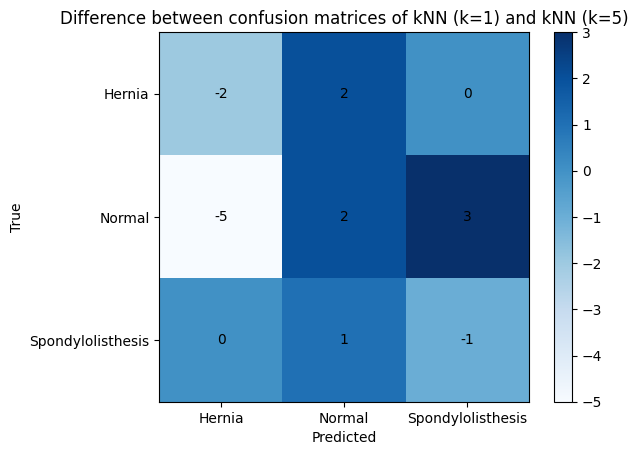

In [132]:
plt.figure()
plt.imshow(dif, cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
for i in range(dif.shape[0]):
    for j in range(dif.shape[1]):
        plt.text(j, i, str(int(dif[i, j])), ha='center', va='center', color='black')
plt.xticks([0, 1, 2], ['Hernia', 'Normal', 'Spondylolisthesis'])
plt.yticks([0, 1, 2], ['Hernia', 'Normal', 'Spondylolisthesis'])
plt.title('Difference between confusion matrices of kNN (k=1) and kNN (k=5)')
plt.show()

Na diagonal, um valor igual a zero implica que ambos os classificadores tiveram o mesmo número de classificações corretas nessas classes. Se o valor for positivo, o kNN com k=1 teve um maior número de classificações corretas e se o valor for negativo, o kNN com k=5 teve um maior número de classificações corretas. Para os valores fora da diagonal, se estes forem positivos, implica um maior erro na classificação do kNN (k=1) e se forem negativos, implica um maior erro de classificação do kNN (k=5). Assim, analisando a diagonal da matriz, verificamos que o kNN com k=1 funciona melhor para a classe 'Normal' e 'Spondylolisthesis', enquanto que o kNN com k=5 é melhor para a classe 'Hernia'.

### **Exercício 3**  <h3>

A primeira dificuldade que podemos encontrar, é o facto de que se houver uma classe que ocorre muito mais frequentemente que as outras, o Naive Bayes pode ter dificuldade em prever as classes menos frequentes. Para verificar se esta desvantagem se aplica ao nosso dataset, fizemos um gráfico de barras com o número de instâncias de cada classe.



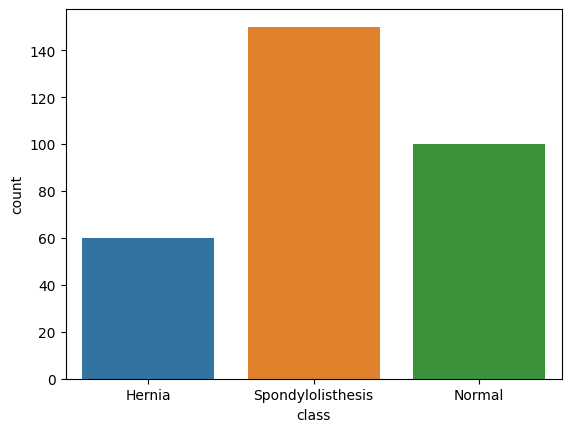

In [133]:
sns.countplot(x='class', data=df)
plt.show()

Pode-se verificar que o número de instâncias de cada classe é diferente, o que pode levar a que o Naive Bayes não seja o classificador mais adequado para este dataset.

Um outro problema que podemos encontrar utilizando o Naive Bayes é o facto de este assumir que as variáveis são independentes entre si. Para verificar se esta desvantagem se aplica ao nosso dataset, fizemos uma matriz de correlação entre as variáveis. Numa matriz de correlação consideramos que as variáveis estão correlacionadas quando o valor é próximo de 1 ou -1 e quanto mais próximas de 0, menor correlacionadas estão.

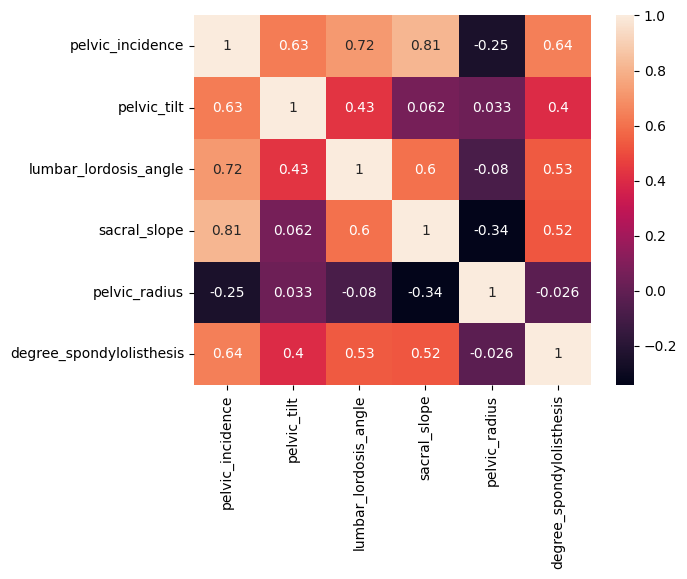

In [134]:
df = df.drop('class', axis=1)
df.corr(method='pearson')
sns.heatmap(df.corr(method='pearson'), annot=True)
plt.show()

Como podemos ver, as variáveis estão bastante correlacionadas entre si, o que mais uma vez, é uma desvantagem na utilização do Naive Bayes neste dataset.

Por fim, o Naive Bayes assume que as variáveis são normalmente distribuídas, o que pode não acontecer. Para verificar se esta desvantagem se aplica ao nosso dataset, fizemos um histograma para cada variável.

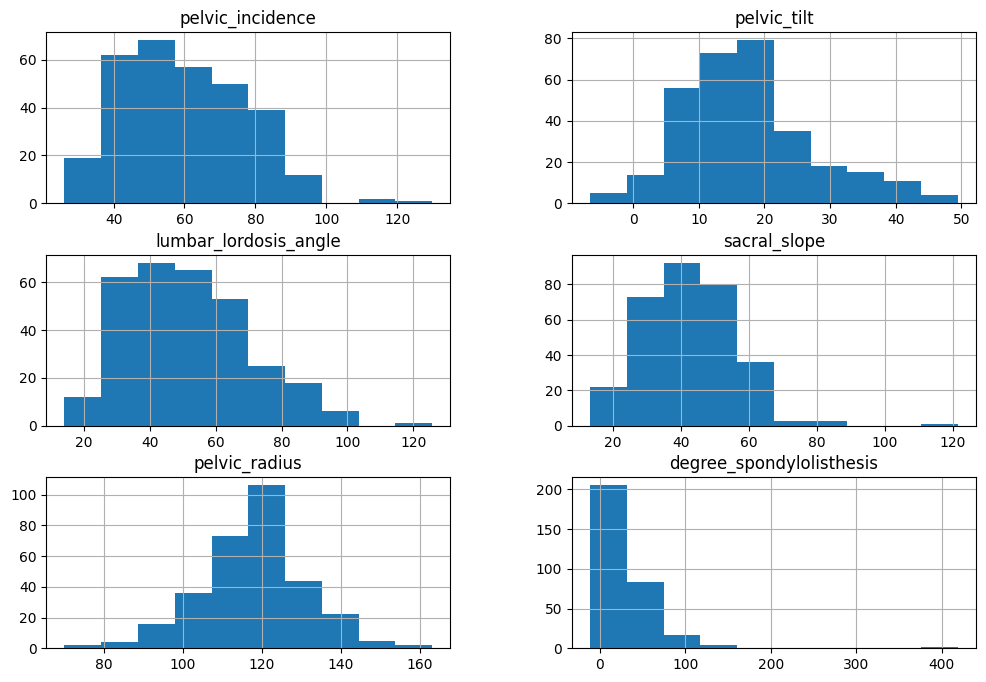

In [135]:
df.hist(figsize=(12, 8))
plt.show()

Como podemos observar, nem todas as variáveis têm uma distribuição gaussiana, o que representa uma desvantagem na utilização do Naive Bayes neste dataset.